In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

from xgboost import XGBClassifier

time: 2.43 s


## Creating the Database and Instantiating a Database Object

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.29 ms


## Populating the Database

**If necessary, run the cell below to populate the database.**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 457 µs


## Preprocessing and Harness Objects
Creating column selectors, transformers, scorers, and a SMOTE instance for the pipeline. Also, instantiating a harness object to record the modeling process.

In [5]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
sm = SMOTE(random_state=2021)

# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.09 ms


## Half Term Data

In order to be able to predict unsatisfactory outcomes while there is still time to intervene, we limited the model to data logged upto the halfway of the courses. Since the median course length is 240 days, a cutoff point of 120 days was chosen. Further, students who withdrew before the 120th day were dropped from the data, since their outcome was fully determined within the 120 day window.

The data was collected into an SQL database, and a data frame was constructed from the various database tables. During the creation process, the multiclass `final_result` feature was binarized into a `target` feature with classes Satisfactory (Pass, Distinction), and Unsatisfactory (Withdrawn, Fail). A `row_id` feature was constructed to identify unique student-course-semester combinations, and a `sum_activity` feature was added to quantify the level of a student's interaction with the course material. Lastly, `weighted_ave`,  `mean_score`, and `median_score` were derived from the each row's  assessment data. 

In [6]:
df = db.data_prep_half(120)

time: 9.9 s


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24770 entries, 0 to 24769
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                23261 non-null  float64
 1   row_id                24770 non-null  object 
 2   score                 23237 non-null  object 
 3   gender                23261 non-null  object 
 4   region                23261 non-null  object 
 5   highest_education     23261 non-null  object 
 6   imd_band              22335 non-null  object 
 7   age_band              23261 non-null  object 
 8   num_of_prev_attempts  23261 non-null  float64
 9   studied_credits       23261 non-null  float64
 10  disability            23261 non-null  object 
 11  final_result          23261 non-null  object 
 12  date_sub              23261 non-null  float64
 13  course_length         23261 non-null  float64
 14  weighted_ave          23255 non-null  float64
 15  mean_score         

## Data Preparation

In [8]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'code_module',
         'code_presentation', 'id_student', 'activity_level']

time: 656 µs


In [9]:
df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 99.5 ms


After the data frame was created various cosmetic fixes were applied to the data, and outliers were dropped from the `studied_credits`, `weighted_ave`, and `sum_activity` features using IQR fences. A categorical `course_load` feature was derived by binning `studied_credits`, and a categorical `activity_level` feature was created by binning `sum_activity`. The `course_load` feature was used during the modeling process, and `activity_level` was used for statistical testing when while investigating business recommendations. Lastly, null values and extraneous columns were dropped in preparation of the modeling process.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19458 entries, 0 to 19457
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                19458 non-null  float64 
 1   gender                19458 non-null  object  
 2   region                19458 non-null  object  
 3   highest_education     19458 non-null  object  
 4   imd_band              19458 non-null  object  
 5   age_band              19458 non-null  object  
 6   num_of_prev_attempts  19458 non-null  float64 
 7   disability            19458 non-null  object  
 8   weighted_ave          19458 non-null  float64 
 9   mean_score            19458 non-null  float64 
 10  median_score          19458 non-null  float64 
 11  sum_activity          19458 non-null  float64 
 12  course_load           19458 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 1.8+ MB
time: 19.9 ms


## Features Used

The following features will be used in the modeling process:
    
-  gender: The gender of the student.
    
-  region: The geographic region of the student.
    
- highest_education: The education level of the student.
    
- imd_band: A measure of economic status based on geographic location.
    
- age_band: The age cohort of the student.
    
- num_of_prev_attempts: The number of times the student has attempted the class.
    
- disability: The disability status of the student.

- weighted_ave: The weighted average of the student's assessment scores.

- mean_score: The student's mean assessment score.

- median_score: The student's median assessment score.

- sum_activity: The sum of the activities, and the number of clicks for each activity, that the student logged.

- course_load: A three level categorization of the total credits the student was enrolled at the time of the  course.
    

## Summary Statistics for the Numerical Features

In [11]:
df.describe()

,target,num_of_prev_attempts,weighted_ave,mean_score,median_score,sum_activity
count,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000
mean,0.359595,0.140713,106.436972,74.288758,74.583256,901.266780
std,0.479894,0.449925,65.628103,15.207932,15.078946,724.074213
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,60.800000,66.400000,66.500000,345.000000
50%,0.000000,0.000000,113.020000,77.400000,77.500000,694.000000
75%,1.000000,0.000000,152.000000,85.000000,85.000000,1268.750000
max,1.000000,6.000000,299.920000,100.000000,100.000000,3179.000000


time: 51.1 ms


## Creating Holdout Data

In [12]:
# splitting data & target
X, y = f.X_y(df)

time: 2.59 ms


In [13]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 10.5 ms


## Creating Training Data

In [14]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.33 ms


In [15]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 3.59 ms


# Modeling

Since we want to indentify as many unsatisfactory outcomes possible while still minimizing false positives, we will use F1 as the metric of our models.

## Baseline Model: Dummy Classifier
The classifier will predict the minority class for each observation.

In [16]:
dummy = DummyClassifier(strategy='constant', constant=1)

time: 609 µs


In [17]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 749 µs


### Fitting Model

In [18]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>)])),
                ('dummyclassifier',
                 DummyClassifier(constant=1, strategy='constant'))])

time: 45.4 ms


### Saving Model

In [19]:
# f.pickle_model(baseline, 'baseline')

time: 1.66 ms


### Cross Val Scores

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.3596491264699766
 Baseline has an average F1 of 0.5290322368027472
 Baseline has an average Recall of 1.0
 Baseline has an average Precision of 0.3596491264699766
time: 192 ms


### Test Data Confusion Matrix

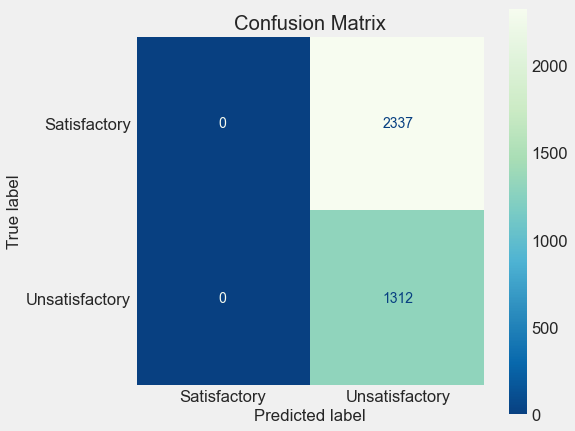

,Accuracy,F1,Recall,Precision
0,0.359551,0.528926,1.0,0.359551


time: 287 ms


In [21]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## Score Interpretation:

F1 is a mix of both precision and recall, so the interpretation of the results is more easily given in terms of recall and precision.

- From the confusion matrix we see that the baseline model is classifying everything as the minority class, which was expected.
- All Unsatisfactory outcomes were correctly classified as Unsatisfactory, so the recall score for this model is 1. 
- The precision score of .36 indicates that 36% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

## First Simple Model: Naive Bayes Classifier
We will use a basic classifier for our first simple model.

In [22]:
mnb = MultinomialNB()

time: 544 µs


In [23]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 663 µs


### Fitting Model

In [24]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>)])),
                ('multinomialnb', MultinomialNB())])

time: 40.6 ms


### Saving Model

In [25]:
# f.pickle_model(fsm, 'fsm')

time: 454 µs


### Cross Val Scores

In [26]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6447369805651159
 fsm has an average F1 of 0.27759213371791497
 fsm has an average Recall of 0.18978579583201646
 fsm has an average Precision of 0.5175573546203541
time: 196 ms


### Test Data Confusion Matrix

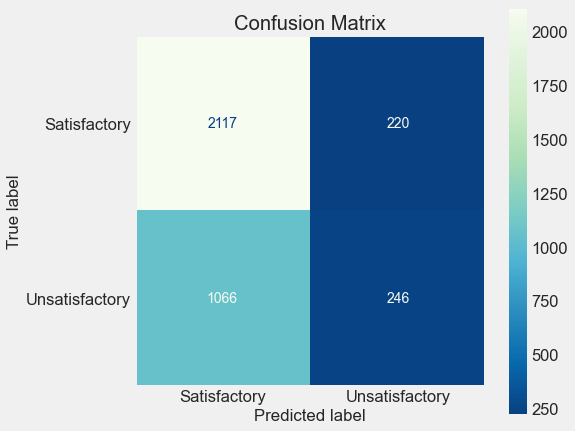

,Accuracy,F1,Recall,Precision
0,0.647575,0.276715,0.1875,0.527897


time: 197 ms


In [27]:
f.confusion_report(fsm, X_test, y_test)

## Score Interpretation:

- From the confusion matrix we see that the fsm model is classifying outcomes slightly better than baseline.
- The recall score of .19 indicates that about 19% outcomes were correctly classified as Unsatisfactory. 
- The precision score .53 indicates that about 53% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Standard Scaling
Since a few of the numerical features differ by orders of magnitude, standard scaling will be implemented to aid in model convergence and performance.

## KNeighborsClassifier

In [28]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 642 µs


In [29]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 705 µs


### Fitting Model

In [30]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 46.7 ms


In [31]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 637 µs


### Cross Val Scores

In [32]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.710343933394745
knn_ss has an average F1 of 0.5622362175375103
knn_ss has an average Recall of 0.5172808132147395
knn_ss has an average Precision of 0.6160075501796807
time: 3.64 s


### Test Data Confusion Matrix

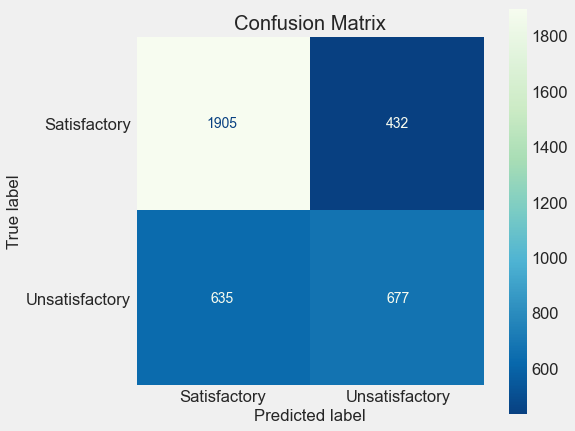

,Accuracy,F1,Recall,Precision
0,0.707591,0.559273,0.516006,0.61046


time: 7.3 s


In [33]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [34]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 712 µs


In [35]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.29 ms


### Fitting Model

In [36]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.97 s


### Cross Val Scores

In [37]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7317252291038038
logreg_ss has an average F1 of 0.5708974826376763
logreg_ss has an average Recall of 0.496697605118712
logreg_ss has an average Precision of 0.671986979987122
time: 7.4 s


### Test Data Confusion Matrix

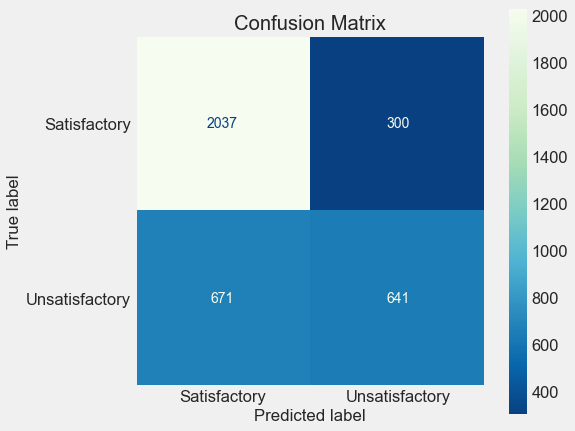

,Accuracy,F1,Recall,Precision
0,0.7339,0.569019,0.488567,0.68119


time: 206 ms


In [38]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [39]:
SVC = SVC()

time: 661 µs


In [40]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 729 µs


### Fitting Model

In [41]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('svc', SVC())])

time: 4.86 s


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7444256766631896
svc_ss has an average F1 of 0.5863313032730525
svc_ss has an average Recall of 0.5040654286985855
svc_ss has an average Precision of 0.7013273063457831
time: 18.1 s


### Test Data Confusion Matrix

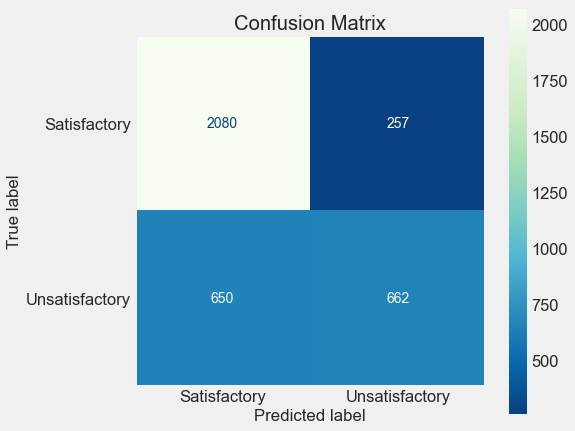

,Accuracy,F1,Recall,Precision
0,0.751439,0.593456,0.504573,0.720348


time: 5.54 s


In [43]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [44]:
LSVC = LinearSVC(random_state=2021)

time: 638 µs


In [45]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 756 µs


### Fitting Model

In [46]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('linearsvc', LinearSVC(random_state=2021))])

time: 635 ms


### Cross Val Scores

In [47]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7303546985383959
lsvc_ss has an average F1 of 0.5632846665047779
lsvc_ss has an average Recall of 0.48399402730925767
lsvc_ss has an average Precision of 0.6745561565674398
time: 2.49 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

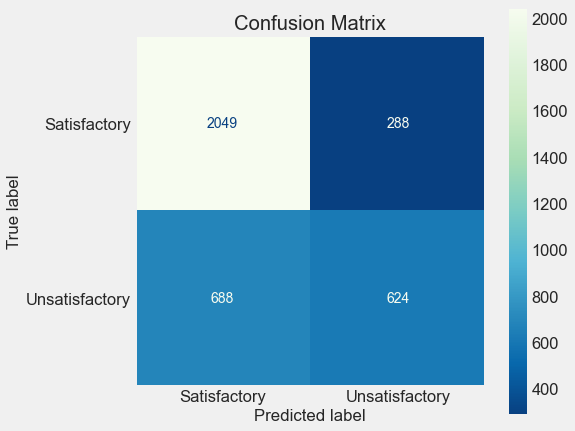

,Accuracy,F1,Recall,Precision
0,0.732529,0.561151,0.47561,0.684211


time: 228 ms


In [48]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [49]:
DT = DecisionTreeClassifier(random_state=2021)

time: 693 µs


In [50]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 808 µs


### Fitting Model

In [51]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 416 ms


### Cross Val Scores

In [52]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6856722535730004
dt_ss has an average F1 of 0.567441655954861
dt_ss has an average Recall of 0.5734270086881365
dt_ss has an average Precision of 0.5616731934970407
time: 1.6 s


### Test Data Confusion Matrix

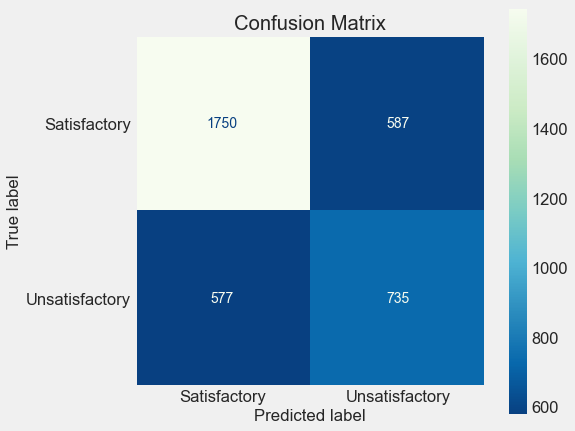

,Accuracy,F1,Recall,Precision
0,0.681008,0.558087,0.560213,0.555976


time: 217 ms


In [53]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [54]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 709 µs


In [55]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 710 µs


### Fitting Model

In [56]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 2.67 s


### Cross Val Scores

In [57]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7477155596830756
bclf_ss has an average F1 of 0.6033710907163397
bclf_ss has an average Recall of 0.5337856926321765
bclf_ss has an average Precision of 0.6943330804123302
time: 9.58 s


### Test Data Confusion Matrix

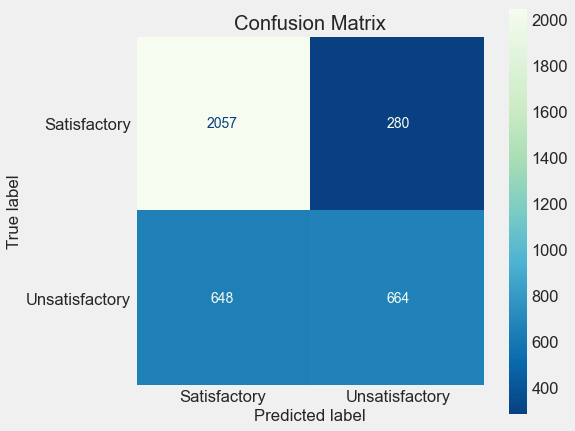

,Accuracy,F1,Recall,Precision
0,0.745684,0.588652,0.506098,0.70339


time: 291 ms


In [58]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [59]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 765 µs


In [60]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 742 µs


### Fitting Model

In [61]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 1.91 s


### Cross Val Scores

In [62]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7580408691287583
rf_ss has an average F1 of 0.6262316744160861
rf_ss has an average Recall of 0.5637726636523713
rf_ss has an average Precision of 0.7046611733083759
time: 9.57 s


### Test Data Confusion Matrix

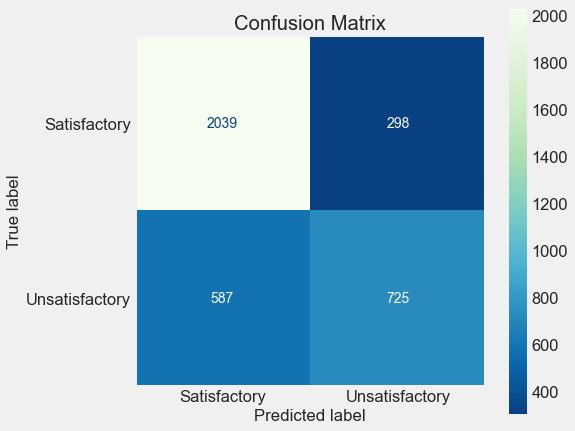

,Accuracy,F1,Recall,Precision
0,0.757468,0.620985,0.552591,0.7087


time: 464 ms


In [63]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [64]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 723 µs


In [65]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 783 µs


### Fitting Model

In [66]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 511 ms


### Cross Val Scores

In [67]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6881395927618815
ada_ss has an average F1 of 0.5712699490285533
ada_ss has an average Recall of 0.5777446319958204
ada_ss has an average Precision of 0.5650618995678235
time: 1.69 s


### Test Data Confusion Matrix

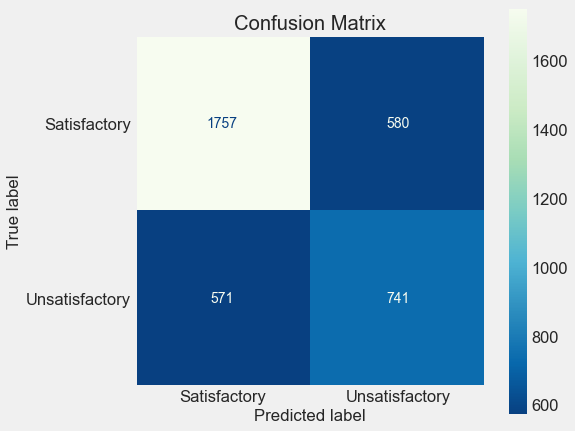

,Accuracy,F1,Recall,Precision
0,0.684571,0.562856,0.564787,0.560939


time: 229 ms


In [68]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [69]:
XGB = XGBClassifier(use_label_encoder=False, verbosity=0)

time: 856 µs


In [70]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 854 µs


### Fitting Model

In [71]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 747 ms


### Cross Val Scores

In [72]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 3.35 s


### Test Data Confusion Matrix

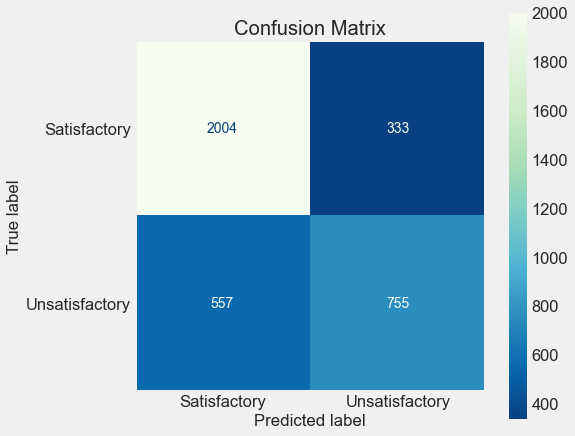

,Accuracy,F1,Recall,Precision
0,0.756098,0.629167,0.575457,0.693934


time: 378 ms


In [73]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary

In [74]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.644737,0.277592,0.189786,0.517557,0.192745,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.188493,Baseline DummyCFL
2,knn_ss,0.710344,0.562236,0.517281,0.616008,3.633001,KNN SS()
3,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.488851,Linear SVC SS()
4,dt_ss,0.685672,0.567442,0.573427,0.561673,1.594649,Decision Tree CLF SS()
5,logreg_ss,0.731725,0.570897,0.496698,0.671987,7.392823,LogReg SS()
6,ada_ss,0.688140,0.571270,0.577745,0.565062,1.690770,AdaBoost SS()
7,svc_ss,0.744426,0.586331,0.504065,0.701327,18.133386,Support Vector CLF SS()
8,bclf_ss,0.747716,0.603371,0.533786,0.694333,9.573603,Bagging CLF SS()
9,rf_ss,0.758041,0.626232,0.563773,0.704661,9.569614,Random Forest SS()


time: 10.6 ms


## Voting Classifier (BCLF, RF, XGBoost)
Using the top three models in a voting classifier.

In [75]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.23 ms


In [76]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 1.12 ms


### Fitting Model

In [77]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.95 s


### Cross Val Scores

In [78]:
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

vc_ss has an average Accuracy of 0.7640708946093272
vc_ss has an average F1 of 0.6402318177517269
vc_ss has an average Recall of 0.5838382600506968
vc_ss has an average Precision of 0.7091504825134183
time: 21.1 s


In [79]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.644737,0.277592,0.189786,0.517557,0.192745,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.188493,Baseline DummyCFL
2,knn_ss,0.710344,0.562236,0.517281,0.616008,3.633001,KNN SS()
3,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.488851,Linear SVC SS()
4,dt_ss,0.685672,0.567442,0.573427,0.561673,1.594649,Decision Tree CLF SS()
5,logreg_ss,0.731725,0.570897,0.496698,0.671987,7.392823,LogReg SS()
6,ada_ss,0.688140,0.571270,0.577745,0.565062,1.690770,AdaBoost SS()
7,svc_ss,0.744426,0.586331,0.504065,0.701327,18.133386,Support Vector CLF SS()
8,bclf_ss,0.747716,0.603371,0.533786,0.694333,9.573603,Bagging CLF SS()
9,rf_ss,0.758041,0.626232,0.563773,0.704661,9.569614,Random Forest SS()


time: 29.3 ms


## Initial Modeling Summary

Implementation of standard scaling and more advanced algorithms has greatly improved performance, with the highest performing model achieving:

- Mean F1 = 0.64
- Mean recall = 0.58
- Mean precision = 0.71

This model is a voting classifier consisting of a bagging classifier, a random forest classifier, and and extreme boosting (XGBoost) classifier.

### Test Data Confusion Matrix

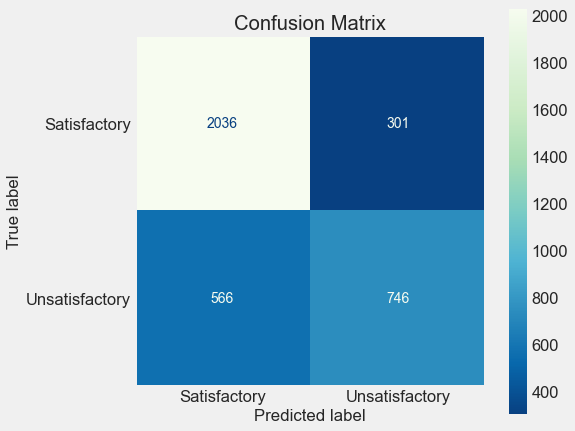

,Accuracy,F1,Recall,Precision
0,0.762401,0.632471,0.568598,0.712512


time: 1.02 s


In [80]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Top Model Score Interpretation:
The confusion matrix indicates that the  voting classifier is still having trouble identifying Unsatisfactory outcomes.
- The recall score of .57 indicates that about 57% outcomes were correctly classified as Unsatisfactory. 
- The precision score .71 indicates that about 71% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# SMOTE

In [81]:
df.target.value_counts(normalize=True)

0.0    0.640405
1.0    0.359595
Name: target, dtype: float64

time: 5.89 ms


Since the classes have an imbalance of around 2 to 1, SMOTE will be added to the pipeline in an attempt to aid model performance.

## Voting CLF SMOTE

In [82]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [ ('bclf', clf1), ('rf', clf2), ('xgb', clf3)]
VC = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

time: 1.4 ms


In [83]:
vc_sm = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.05 ms


### Fitting Model

In [84]:
%%capture --no-display
vc_sm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x114016130>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 8.96 s


### Cross Val Scores

In [85]:
# %%capture --no-display
# checking cross val scores
modeling.report(vc_sm, X_train, y_train, 'vc_sm',\
                'Voting CLF SS()/SMOTE SOFT')

vc_sm has an average Accuracy of 0.7615122730154009
vc_sm has an average F1 of 0.6585042104593446
vc_sm has an average Recall of 0.6394797438063972
vc_sm has an average Precision of 0.678897497764228
time: 34.7 s


## Model Summary

In [86]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.644737,0.277592,0.189786,0.517557,0.192745,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.188493,Baseline DummyCFL
2,knn_ss,0.710344,0.562236,0.517281,0.616008,3.633001,KNN SS()
3,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.488851,Linear SVC SS()
4,dt_ss,0.685672,0.567442,0.573427,0.561673,1.594649,Decision Tree CLF SS()
5,logreg_ss,0.731725,0.570897,0.496698,0.671987,7.392823,LogReg SS()
6,ada_ss,0.688140,0.571270,0.577745,0.565062,1.690770,AdaBoost SS()
7,svc_ss,0.744426,0.586331,0.504065,0.701327,18.133386,Support Vector CLF SS()
8,bclf_ss,0.747716,0.603371,0.533786,0.694333,9.573603,Bagging CLF SS()
9,rf_ss,0.758041,0.626232,0.563773,0.704661,9.569614,Random Forest SS()


time: 18.3 ms


### Test Data Confusion Matrix

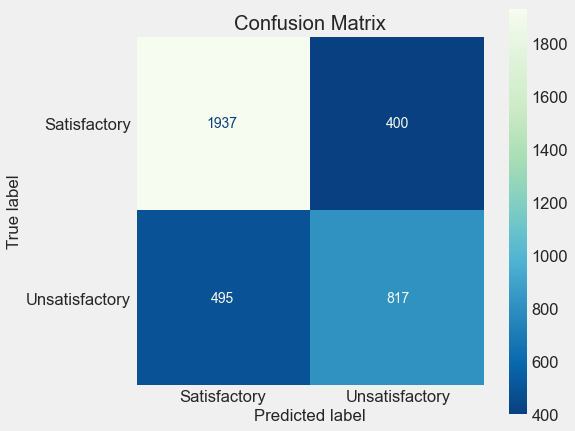

,Accuracy,F1,Recall,Precision
0,0.754727,0.646105,0.622713,0.671323


time: 814 ms


In [87]:
%%capture --no-display
f.confusion_report(vc_sm, X_test, y_test)

## Score Interpretation:

Upon validation with the test data we see that the model is still having some trouble the minority class, but recall has been improved.

- The recall score of .62 indicates that about 62% outcomes were correctly classified as Unsatisfactory.
- The precision score .67 indicates that about 67% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Hyperparameter Tuning

In [88]:
# getting params
vc_sm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'smote', 'votingclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifie

time: 4.42 ms


## Separating the Parameters by Classifier

### BCLF

In [89]:
bag_params = ['votingclassifier__bclf__base_estimator__ccp_alpha', 
              'votingclassifier__bclf__base_estimator__class_weight',
              'votingclassifier__bclf__base_estimator__criterion', 
              'votingclassifier__bclf__base_estimator__max_depth', 
              'votingclassifier__bclf__base_estimator__max_features', 
              'votingclassifier__bclf__base_estimator__max_leaf_nodes', 
              'votingclassifier__bclf__base_estimator__min_impurity_decrease', 
              'votingclassifier__bclf__base_estimator__min_impurity_split', 
              'votingclassifier__bclf__base_estimator__min_samples_leaf', 
              'votingclassifier__bclf__base_estimator__min_samples_split', 
              'votingclassifier__bclf__base_estimator__min_weight_fraction_leaf', 
              'votingclassifier__bclf__base_estimator__random_state', 
              'votingclassifier__bclf__base_estimator__splitter', 
              'votingclassifier__bclf__base_estimator', 
              'votingclassifier__bclf__bootstrap', 
              'votingclassifier__bclf__bootstrap_features', 
              'votingclassifier__bclf__max_features', 
              'votingclassifier__bclf__max_samples',
              'votingclassifier__bclf__n_estimators', 
              'votingclassifier__bclf__n_jobs', 
              'votingclassifier__bclf__oob_score', 
              'votingclassifier__bclf__random_state', 
              'votingclassifier__bclf__verbose', 
              'votingclassifier__bclf__warm_start']

time: 1.5 ms


### RF

In [90]:
rf_params = ['votingclassifier__rf__bootstrap',
             'votingclassifier__rf__ccp_alpha', 
             'votingclassifier__rf__class_weight', 
             'votingclassifier__rf__criterion', 
             'votingclassifier__rf__max_depth', 
             'votingclassifier__rf__max_features', 
             'votingclassifier__rf__max_leaf_nodes', 
             'votingclassifier__rf__max_samples', 
             'votingclassifier__rf__min_impurity_decrease', 
             'votingclassifier__rf__min_impurity_split', 
             'votingclassifier__rf__min_samples_leaf', 
             'votingclassifier__rf__min_samples_split', 
             'votingclassifier__rf__min_weight_fraction_leaf', 
             'votingclassifier__rf__n_estimators', 
             'votingclassifier__rf__n_jobs', 
             'votingclassifier__rf__oob_score', 
             'votingclassifier__rf__random_state', 
             'votingclassifier__rf__verbose',
             'votingclassifier__rf__warm_start']

time: 1.21 ms


### XGB

In [91]:
xgb_params = ['votingclassifier__xgb__objective', 
              'votingclassifier__xgb__use_label_encoder', 
              'votingclassifier__xgb__base_score', 
              'votingclassifier__xgb__booster', 
              'votingclassifier__xgb__colsample_bylevel', 
              'votingclassifier__xgb__colsample_bynode', 
              'votingclassifier__xgb__colsample_bytree', 
              'votingclassifier__xgb__gamma', 
              'votingclassifier__xgb__gpu_id', 
              'votingclassifier__xgb__importance_type', 
              'votingclassifier__xgb__interaction_constraints', 
              'votingclassifier__xgb__learning_rate', 
              'votingclassifier__xgb__max_delta_step', 
              'votingclassifier__xgb__max_depth', 
              'votingclassifier__xgb__min_child_weight', 
              'votingclassifier__xgb__missing', 
              'votingclassifier__xgb__monotone_constraints', 
              'votingclassifier__xgb__n_estimators', 
              'votingclassifier__xgb__n_jobs', 
              'votingclassifier__xgb__num_parallel_tree', 
              'votingclassifier__xgb__random_state', 
              'votingclassifier__xgb__reg_alpha', 
              'votingclassifier__xgb__reg_lambda', 
              'votingclassifier__xgb__scale_pos_weight', 
              'votingclassifier__xgb__subsample', 
              'votingclassifier__xgb__tree_method', 
              'votingclassifier__xgb__validate_parameters', 
              'votingclassifier__xgb__verbosity']

time: 1.39 ms


## Setting Parameter Grid
Setting the parameters for tuning and their distributions.

In [92]:
# setting param grid

grid = {'votingclassifier__bclf__base_estimator__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__bclf__base_estimator__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__bclf__base_estimator__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__bclf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__rf__max_depth':\
        np.linspace(1, 32, 32),
        'votingclassifier__rf__max_features':\
        list(range(1,X_train.shape[1])),
        'votingclassifier__rf__min_samples_leaf':\
        np.linspace(0.1, 0.5, 5),
        'votingclassifier__rf__min_samples_split':\
        np.linspace(0.1, 1.0, 10),
        'votingclassifier__xgb__n_estimators':\
        np.linspace(1, 200, 20, dtype='int'),
        'votingclassifier__xgb__colsample_bytree':\
        np.linspace(0.5, 1.0, 10),
        'votingclassifier__xgb__gamma':\
        np.linspace(0, .5, 5),
        'votingclassifier__xgb__learning_rate':\
        np.linspace(0.01, .5, 10),
        'votingclassifier__xgb__max_depth':\
        np.linspace(3, 10, 7, dtype='int'),
        'votingclassifier__xgb__reg_alpha':\
        np.logspace(.001, 2, 10),
        'votingclassifier__xgb__reg_lambda':\
        np.linspace(1, 10, 20)
       }

time: 2.59 ms


## Randomized Search Cross Validation

In [93]:
# instantiating RSCV
param_search = RandomizedSearchCV(vc_sm, param_distributions=grid,
                                  scoring='f1', random_state=2021, cv=10)

time: 918 µs


In [94]:
# fitting RSCV
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x1140160d0>),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x114016130...
                                        'votingclassifier__xgb__reg_alpha': array([  1.00230524,   1.67151821,   2.78754715,   4.64871941,
         7.75254765,  12.92872076, 

time: 3min 42s


In [95]:
# creating search results dataframe
search_results = pd.DataFrame(param_search.cv_results_)\
.sort_values(by='rank_test_score').reset_index(drop=True)

time: 4.34 ms


In [96]:
# checking first five rows
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_votingclassifier__xgb__reg_lambda,param_votingclassifier__xgb__reg_alpha,param_votingclassifier__xgb__n_estimators,param_votingclassifier__xgb__max_depth,param_votingclassifier__xgb__learning_rate,param_votingclassifier__xgb__gamma,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.489286,0.040829,0.037762,0.003123,3.842105,7.752548,21,10,0.173333,0.125,...,0.679790,0.683311,0.658945,0.649418,0.659119,0.667516,0.628571,0.658598,0.019757,1
1,1.362044,0.103786,0.035326,0.005313,7.157895,100.0,42,6,0.336667,0.25,...,0.661939,0.691244,0.656036,0.630359,0.659817,0.681344,0.628571,0.655359,0.020572,2
2,1.961309,0.081582,0.074811,0.009557,3.368421,1.671518,137,3,0.5,0.125,...,0.664865,0.673025,0.649664,0.657682,0.647137,0.665779,0.642473,0.655102,0.019683,3
3,1.580884,0.061668,0.078686,0.010113,5.263158,1.671518,11,8,0.064444,0.5,...,0.664286,0.665871,0.650463,0.629847,0.651163,0.674528,0.639816,0.652681,0.015556,4
4,2.597938,0.332970,0.111152,0.027263,1.947368,21.560889,74,5,0.118889,0.25,...,0.659767,0.677043,0.646388,0.641849,0.668305,0.681648,0.613435,0.652614,0.022117,5


time: 19.7 ms


In [97]:
# checking best params
param_search.best_params_

{'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}

time: 2.88 ms


## Best Params

In [98]:
best_params = {'votingclassifier__xgb__reg_lambda': 3.8421052631578947,
 'votingclassifier__xgb__reg_alpha': 7.75254765345907,
 'votingclassifier__xgb__n_estimators': 21,
 'votingclassifier__xgb__max_depth': 10,
 'votingclassifier__xgb__learning_rate': 0.17333333333333334,
 'votingclassifier__xgb__gamma': 0.125,
 'votingclassifier__xgb__colsample_bytree': 0.8888888888888888,
 'votingclassifier__rf__n_estimators': 53,
 'votingclassifier__rf__min_samples_split': 0.1,
 'votingclassifier__rf__min_samples_leaf': 0.5,
 'votingclassifier__rf__max_features': 4,
 'votingclassifier__rf__max_depth': 27.0,
 'votingclassifier__bclf__max_features': 4,
 'votingclassifier__bclf__base_estimator__min_samples_split': 0.2,
 'votingclassifier__bclf__base_estimator__min_samples_leaf': 0.5,
 'votingclassifier__bclf__base_estimator__max_depth': 21.0}

time: 1.28 ms


# Best Model

In [99]:
# getting best estimator
best_model = param_search.best_estimator_

time: 764 µs


In [100]:
# checking cross val scores
modeling.report(best_model, X_train, y_train, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT')

best_model has an average Accuracy of 0.7593199920159213
best_model has an average F1 of 0.6613449865812424
best_model has an average Recall of 0.653456227142848
best_model has an average Precision of 0.6696263324427678
time: 8.26 s


## Modeling Summary

In [101]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,fsm,0.644737,0.277592,0.189786,0.517557,0.192745,FSM Naive Bayes
1,Baseline,0.359649,0.529032,1.000000,0.359649,0.188493,Baseline DummyCFL
2,knn_ss,0.710344,0.562236,0.517281,0.616008,3.633001,KNN SS()
3,lsvc_ss,0.730355,0.563285,0.483994,0.674556,2.488851,Linear SVC SS()
4,dt_ss,0.685672,0.567442,0.573427,0.561673,1.594649,Decision Tree CLF SS()
5,logreg_ss,0.731725,0.570897,0.496698,0.671987,7.392823,LogReg SS()
6,ada_ss,0.688140,0.571270,0.577745,0.565062,1.690770,AdaBoost SS()
7,svc_ss,0.744426,0.586331,0.504065,0.701327,18.133386,Support Vector CLF SS()
8,bclf_ss,0.747716,0.603371,0.533786,0.694333,9.573603,Bagging CLF SS()
9,rf_ss,0.758041,0.626232,0.563773,0.704661,9.569614,Random Forest SS()


time: 16 ms


## Final Modeling Summary

Hyperparameter tuning has greatly improved the speed of the and slightly improved performance during 5-fold cross validation, with the model achieving: 
- Mean F1 = 0.66
- Mean recall = 0.65
- Mean precision = 0.67

### Test Data Confusion Matrix

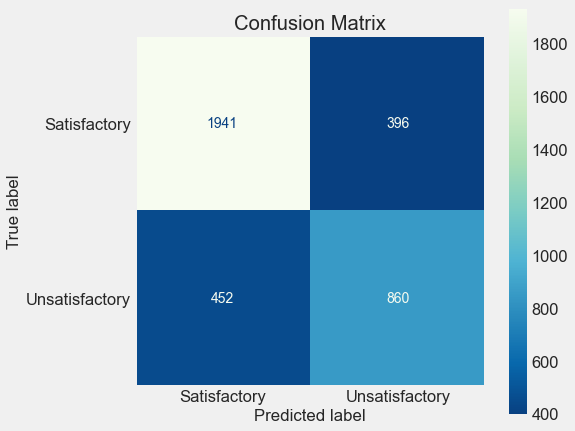

,Accuracy,F1,Recall,Precision
0,0.767608,0.669782,0.655488,0.684713


time: 546 ms


In [102]:
f.confusion_report(best_model, X_test, y_test)

## Final Model Test Score Interpretation:

Upon validation with the test data we see that the model is still having some trouble the minority class, but performance has been improved to a level that is acceptable for our purposes.

- The recall score of .66 indicates that about 66% outcomes were correctly classified as Unsatisfactory.
- The precision score .68 indicates that about 68% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# Saving Model

In [103]:
# saving the model
# f.pickle_model(best_model, 'final')

time: 654 µs


# F1 Permutation Importances

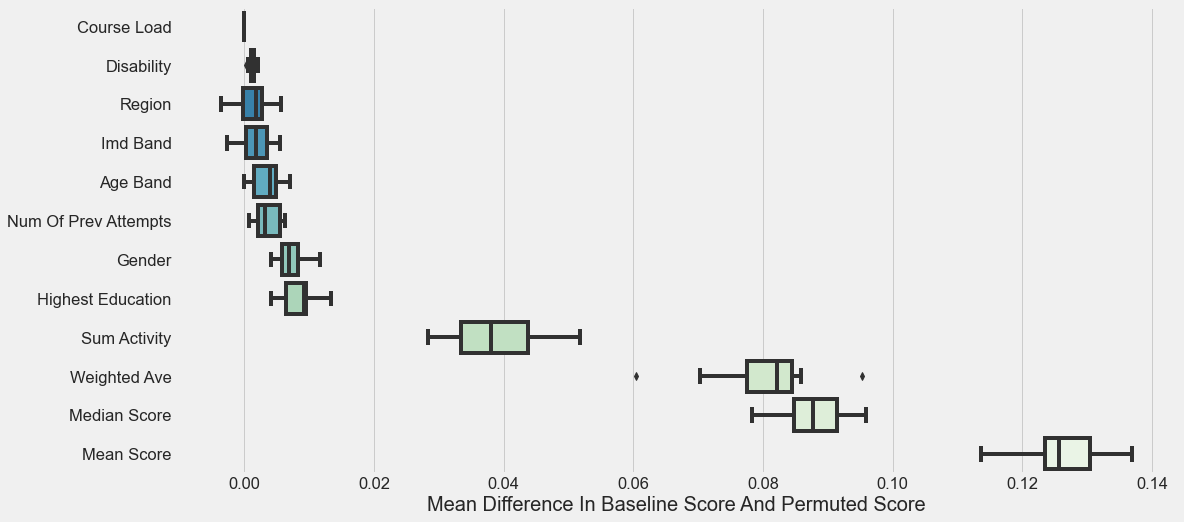

time: 4.29 s


In [104]:
f.perm_importances(best_model, X_test, y_test, 'f1')

The assessment score features (median_score, mean_score & weighted_ave) are the main drivers of the model. Interestingly, some of the most statistically significant features (imd_band, highest_education, and course_load) have little to no effect on the model.

# Validating Model on Holdout Data

### Average Metrics

In [105]:
# checking cross val scores
modeling.report(best_model, X_holdout, y_holdout, 'best_model',\
                'Tuned Voting CLF SS()/SMOTE SOFT HOLDOUT')

best_model has an average Accuracy of 0.7408016443987667
best_model has an average F1 of 0.6306630954880841
best_model has an average Recall of 0.6157707736389685
best_model has an average Precision of 0.6465969439341758
time: 2.89 s


### Holdout Data Confusion Matrix

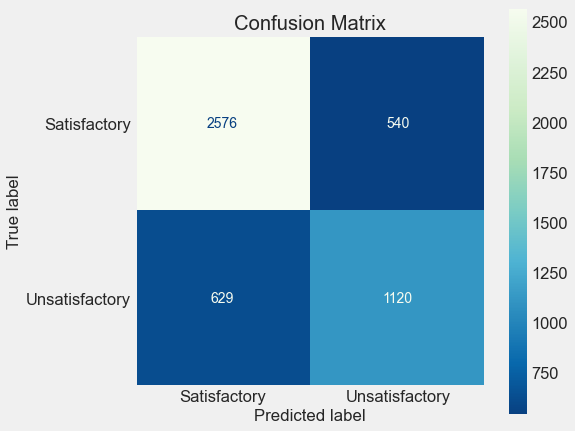

,Accuracy,F1,Recall,Precision
0,0.759712,0.657084,0.640366,0.674699


time: 628 ms


In [106]:
f.confusion_report(best_model, X_holdout, y_holdout)

## Score Interpretation:

Upon validation with the holdout data we see that the model is still having some trouble the minority class, but performance is at a level that is acceptable for our purposes.

- The recall score of .64 indicates that about 64% outcomes were correctly classified as Unsatisfactory.
- The precision score .67 indicates that about 67% of outcomes classified as Unsatisfactory were truly Unsatisfactory.

# ROC AUC

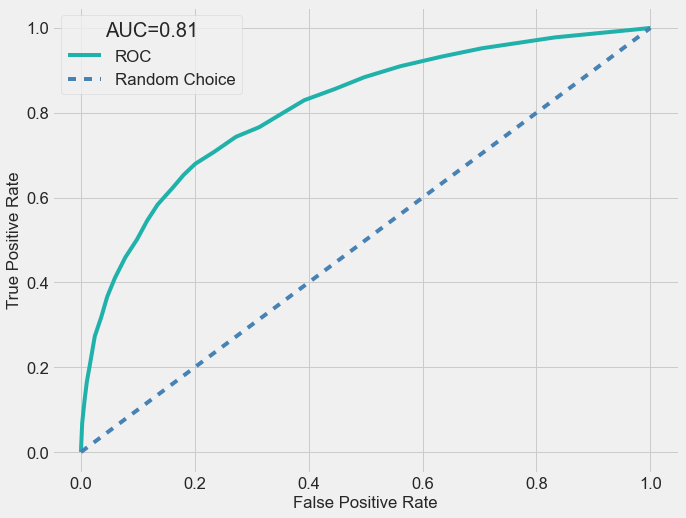

time: 895 ms


In [107]:
f.roc_auc(best_model, X_holdout, y_holdout)

# Saving The Model Fit on All of the Half-Term Data

In [108]:
# fitting model to all of the data
best_model_full = best_model.fit(X,y)

time: 3.96 s


In [109]:
# saving the model
# f.pickle_model(best_model_full, 'final_full_fit')

time: 1.11 ms
